In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
from fastbook import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import MinMaxScaler

This notebook is where I uploaded and briefly played around with the data from my Spotify ETL project.

This was a fun project I did to test the SpotifyAPI and see how well cosine similarity would work using audio track features that Spotify provides to determine how similar tracks are to each other.

The project can be found on my GitHub at: https://github.com/Toodoi/Spotify-ETL-project.

I downloaded 106 unique tracks using the SpotifyAPI and also downloaded a set of audio features for each track. The features are all 

In [2]:
#hide
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('./drive/MyDrive/spotify_df')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df.head()

,tracks,artists,ids,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,feature_vector
0,Norf Norf,Vince Staples,4uQ7wYsuL0DryknoDc11Hk,0.925,0.549,7.0,-6.572,1.0,0.0656,0.39600,0.000154,0.1100,0.0904,100.014,"[0.925, 0.549, 7, -6.572, 1, 0.0656, 0.396, 0.000154, 0.11, 0.0904, 100.014]"
1,UN DIA (ONE DAY) (Feat. Tainy),J Balvin,0EhpEsp4L0oRGM0vmeaN5e,0.571,0.693,6.0,-8.234,0.0,0.0545,0.00536,0.000000,0.1730,0.3930,168.169,"[0.571, 0.693, 6, -8.234, 0, 0.0545, 0.00536, 0, 0.173, 0.393, 168.169]"
2,Prisoner (feat. Dua Lipa),Miley Cyrus,2Oycxb8QbPkpHTo8ZrmG0B,0.781,0.670,3.0,-3.912,0.0,0.0452,0.01030,0.000000,0.0761,0.5950,127.990,"[0.781, 0.67, 3, -3.912, 0, 0.0452, 0.0103, 0, 0.0761, 0.595, 127.99]"
3,Levitating (feat. DaBaby),Dua Lipa,5nujrmhLynf4yMoMtj8AQF,0.702,0.825,6.0,-3.787,0.0,0.0601,0.00883,0.000000,0.0674,0.9150,102.977,"[0.702, 0.825, 6, -3.787, 0, 0.0601, 0.00883, 0, 0.0674, 0.915, 102.977]"
4,Selfless,The Strokes,2t0wwvR15fc3K1ey8OiOaN,0.538,0.679,4.0,-4.297,1.0,0.0333,0.19100,0.001750,0.0889,0.0888,121.990,"[0.538, 0.679, 4, -4.297, 1, 0.0333, 0.191, 0.00175, 0.0889, 0.0888, 121.99]"


I dropped some of audio features because they seemed uninteresting or had extremly unimodal distributions so they would not add much to differentiating the vectors for cosine similarity testing. I also dropped duplicates and some tracks which couldn't pick up audio features from the API.

In [4]:
df = df.drop(['mode', 'instrumentalness', 'speechiness', 'liveness'], axis=1)
df = df.drop_duplicates('tracks')
df = df.drop(df.index[106:114])

In [5]:
df

,tracks,artists,ids,danceability,energy,key,loudness,acousticness,valence,tempo,feature_vector
0,Norf Norf,Vince Staples,4uQ7wYsuL0DryknoDc11Hk,0.925,0.549,7.0,-6.572,0.39600,0.0904,100.014,"[0.925, 0.549, 7, -6.572, 1, 0.0656, 0.396, 0.000154, 0.11, 0.0904, 100.014]"
1,UN DIA (ONE DAY) (Feat. Tainy),J Balvin,0EhpEsp4L0oRGM0vmeaN5e,0.571,0.693,6.0,-8.234,0.00536,0.3930,168.169,"[0.571, 0.693, 6, -8.234, 0, 0.0545, 0.00536, 0, 0.173, 0.393, 168.169]"
2,Prisoner (feat. Dua Lipa),Miley Cyrus,2Oycxb8QbPkpHTo8ZrmG0B,0.781,0.670,3.0,-3.912,0.01030,0.5950,127.990,"[0.781, 0.67, 3, -3.912, 0, 0.0452, 0.0103, 0, 0.0761, 0.595, 127.99]"
3,Levitating (feat. DaBaby),Dua Lipa,5nujrmhLynf4yMoMtj8AQF,0.702,0.825,6.0,-3.787,0.00883,0.9150,102.977,"[0.702, 0.825, 6, -3.787, 0, 0.0601, 0.00883, 0, 0.0674, 0.915, 102.977]"
4,Selfless,The Strokes,2t0wwvR15fc3K1ey8OiOaN,0.538,0.679,4.0,-4.297,0.19100,0.0888,121.990,"[0.538, 0.679, 4, -4.297, 1, 0.0333, 0.191, 0.00175, 0.0889, 0.0888, 121.99]"
...,...,...,...,...,...,...,...,...,...,...,...
101,I Follow Rivers - The Magician Remix,Lykke Li,4Jv7lweGIUOFQ7Oq2AtAh9,0.786,0.696,9.0,-5.796,0.02340,0.3060,121.974,"[0.786, 0.696, 9, -5.796, 0, 0.0428, 0.0234, 0.0019, 0.0839, 0.306, 121.974]"
102,Teenage Crime,Adrian Lux,46LTPfvrxlgNLyIGBup4O2,0.647,0.843,2.0,-4.801,0.01920,0.3280,128.015,"[0.647, 0.843, 2, -4.801, 1, 0.0364, 0.0192, 0.686, 0.104, 0.328, 128.015]"
103,Embrace,PNAU,4dns9UEYXX2BTPHK6BGQ2M,0.638,0.955,6.0,-4.008,0.00275,0.4150,127.988,"[0.638, 0.955, 6, -4.008, 0, 0.0405, 0.00275, 0.000379, 0.223, 0.415, 127.988]"
104,Stand by Me,Oasis,2gANywSFYF58YFMPdDSAjC,0.214,0.828,7.0,-2.660,0.01420,0.3880,169.876,"[0.214, 0.828, 7, -2.66, 1, 0.0383, 0.0142, 1.61e-06, 0.161, 0.388, 169.876]"


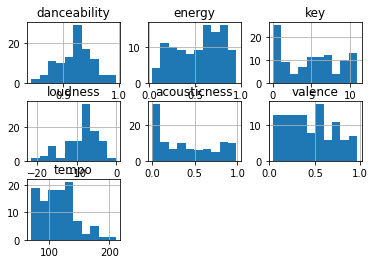

In [6]:
df.hist()
plt.show()

The math for cosine similarity is just the dot product of the two vectors divided by the product of the magnitude of each vector.

In [7]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    
    return dot_product / (norm_a * norm_b)

In [8]:
# Normalize features
features = df[['danceability', 'energy', 'key', 'loudness', 'acousticness', 'valence', 'tempo']]
norm = MinMaxScaler().fit(features)
vec_norm = norm.transform(features)

In [9]:
sim_list = []
idx_list = []

for first_vector in range(0, 106):
    for second_vector in range(first_vector, 105):
        sim = cos_sim(vec_norm[first_vector], vec_norm[second_vector+1])
        sim_list.append(sim)
        idx_list.append((first_vector,second_vector+1))

df_sim = pd.DataFrame({'Similarity' : sim_list, 'Indexes': idx_list})

There were 5,565 similarity pairs calculated and the distribution is plotted below. For cosine similarity, the value can range between 0 and 1 depending on the angle which indicates how similar two vectors are to each other.

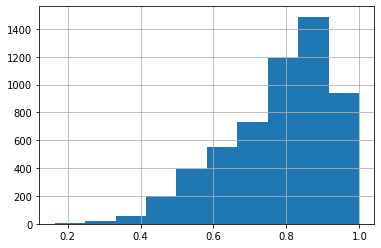

In [10]:
df_sim.Similarity.hist()
plt.show()

In [11]:
len(sim_list)

5565